In [2]:
import torch
import torch.nn as nn
class Reshape(torch.nn.Module):#想使用nn.Sequential，给输入用的
    def forward(self,x):
        return x.view(-1,1,28,28)#批量数，通道数，高度，宽度
net=nn.Sequential(
    Reshape(),
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d((2,2),stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d((2,2),stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)
X=torch.rand(size=(1,1,28,28))
for layer in net:#因为是nn.Sequential构造的，所有可以把每一层拿出来
    X=layer(X)
    print(layer.__class__.__name__,"output shape: \t",X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.utils
import torch.utils.data
import torchvision.transforms as transforms
import torchvision

    
class Timer(object):
    def __init__(self) -> None:
        self.times=[]
        self.start()
    def start(self):
        self.tik=time.time()
    
    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    
    def sum(self):
        return sum(self.times)
    
class Accumulator(object):
    "给n个变量进行累加"
    def __init__(self,n):
        self.data=[0.0 ]*n

    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]

    def __getitem__(self,idx):
        return self.data[idx]
def evaluate_accuracy_gpu(net,data_loader,device=None):#@save
    if isinstance(net,nn.Module):
        net.eval()
        if device is None:
            device=next(iter(net.parameters())).device
        metric=Accumulator(2)
        with torch.no_grad():
            for X,y in data_loader:
                if isinstance(X,list):
                    X=[x.to(device) for x in X]
                else:
                    X=X.to(device)
                y=y.to(device)
                y_hat=net(X)
                y_pred=torch.argmax(y_hat,dim=1).reshape(-1,1).detach().cpu().numpy()
                y_label=y.detach().cpu().numpy()
                metric.add(accuracy_score(y_pred,y_label,normalize=False),X.shape[0])#获取tensor中一共包含多少个元素
                #print("样本数量和标签数量是否相等 ： ",y.numel()==X.shape[0])
    return metric[0]/metric[1]

                

In [4]:
import matplotlib.pyplot as plt
from IPython import display#使用 IPython.display 模块，可以更加灵活和丰富地展示各种类型的内容，提升 Jupyter Notebook 的互动性和可视化效果。
from matplotlib_inline import backend_inline #其作用是在 Jupyter Notebook 中将 Matplotlib 的图形显示格式设置为 SVG。SVG（Scalable Vector Graphics）是一种矢量图形格式，它在浏览器中显示时具有更好的缩放效果和更高的清晰度。
class Animator(object):
    def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,ylim=None,xscale="linear",yscale="linear",fmts=("-","m--","g-","r:"),nrows=1,ncols=1,figsize=(8,6)):
        if legend is None:
            legend=[]
        backend_inline.set_matplotlib_formats("svg")
        self.fig,self.axes=plt.subplots(nrows,ncols,figsize=figsize)
        if nrows*ncols==1:
            self.axes=[self.axes,]
        
        def set_axes(axes,xlabel,ylabel,legend,xlim,ylim,xscale,yscale):
            #lambda 关键字用于创建一个匿名函数。这个 Lambda 函数没有参数。
            axes=self.axes[0]
            axes.set_xlabel(xlabel)
            axes.set_ylabel(ylabel)
            axes.set_xscale(xscale)#设置轴刻度比例:常见的刻度比例有 'linear' 和 'log'。
            axes.set_yscale(yscale)
            axes.set_xlim(xlim)#设置轴范围:例如，xlim=(0, 10) 将 X 轴范围设置为 0 到 10。
            axes.set_ylim(ylim)
            if legend:#设置图例:如果传入了图例标签，则设置图例。
                axes.legend(legend)
            axes.grid()#显示网格:显示网格以便更好地阅读图形。
        self.set_axesfunc=lambda:set_axes(self.axes[0],xlabel,ylabel,legend,xlim,ylim,xscale,yscale)#于 set_axes 函数没有返回值，将 set_axes 直接赋值给 self.set_axesfunc 可能会导致一些问题。封装在 Lambda 表达式中是一种有效的方式，可以在需要时执行 set_axes 函数，并确保所有必要的参数都已正确传递。
        self.X,self.Y,self.fmts=None,None,fmts
    


    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y=[y]
        n=len(y)
        if not hasattr(x,"__len__"):
            x=[x]*n


        if not self.X:
            self.X=[[] for i in range(n)]
        if not self.Y:
            self.Y=[[] for i in range(n)]

        for i,(a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()

        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        
        self.set_axesfunc()
        display.display(self.fig)#使用 display.display(self.fig) 将当前图形显示出来。self.fig 是图形对象。
        display.clear_output(wait=True)#使用 display.clear_output(wait=True) 清除之前的输出，确保图形更新时不留下旧的图形显示。这有助于在动态更新图形时保持界面的整洁。
        #该方法用于将数据点添加到图表中，清除旧的图形内容，重新绘制所有数据系列，并更新显示。通过这种方式，可以动态地更新图表内容，适用于需要实时或逐步更新图表的场景。
        
                

            

        
    def save(self, filepath):
        self.fig.savefig(filepath)
 
            

In [5]:
def train(net,train_dataloader,test_dataloader,num_epochs,lr,device):
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)#首先，我们知道pytorch的任何网络net，都是torch.nn.Module的子类,都算是module，也就是模块。pytorch中的model.apply(fn)会递归地将函数fn应用到父模块的每个子模块submodule，也包括model这个父模块自身。比如下面的网络例子中。net这个模块有两个子模块，分别为Linear(2,4)和Linear(4,8)。函数首先对Linear(2,4)和Linear(4,8)两个子模块调用init_weights函数，即print(m)打印Linear(2,4)和Linear(4,8)两个子模块。然后再对net模块进行同样的操作。如此完成递归地调用。从而完成model.apply(fn)或者net.apply(fn)。


    net.apply(init_weights)#
    print("training on now,device = ",device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr)
    cretrion=nn.CrossEntropyLoss()#计算所有样本的平均损失（ reduction 参数默认为 'mean'）：
    animator=Animator(xlabel="epoch",xlim=[1,num_epochs],legend=["train loss","train acc","test acc"])
    timer,num_batches=Timer(),len(train_dataloader)
    for epoch in range(num_epochs):
        metric=Accumulator(n=3)
        net.train()
        for i,(X,y) in enumerate(train_dataloader):
            #print("X = ",X)
            #print("y = ",y)
            timer.start()
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            loss=cretrion(y_hat,y)#l 是当前批次的平均损失值。
            loss.backward()
            optimizer.step()
            y_pre=torch.argmax(y_hat,dim=1).reshape(-1,1).detach().cpu().numpy()
            y_label=y.detach().cpu().numpy()
            with torch.no_grad():#乘以 X.shape[0] 后，得到的是当前批次的总损失（即每个样本的损失值之和）。
                metric.add(loss*X.shape[0],accuracy_score(y_pre,y_label,normalize=False),X.shape[0])#normalize=False计算预测正确的数量
            timer.stop()
            train_loss_mean=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            if (i+1)%(len(train_dataloader)//5)==0 or i==len(train_dataloader)-1:
                animator.add(epoch+(i+1)/num_batches,(train_loss_mean,train_acc,None))
                #print("epoch+(i+1)/num_batches=",epoch+(i+1)/num_batches,"train_loss_mean=",train_loss_mean,"train_acc=",train_acc)
        test_acc=evaluate_accuracy_gpu(net,test_dataloader)
        animator.add(epoch,(None,None,test_acc))
        #print("epoch=",epoch,"test_acc=",test_acc)
    print(f"loss {train_loss_mean:.3f},train_acc {train_acc:.3f},test acc {test_acc:.3f}")
    print(f"{metric[2]*num_epochs/timer.sum():2f} examples/sec on {str(device)}")     

loss 2.295,train_acc 0.174,test acc 0.101
20597.479892 examples/sec on cuda


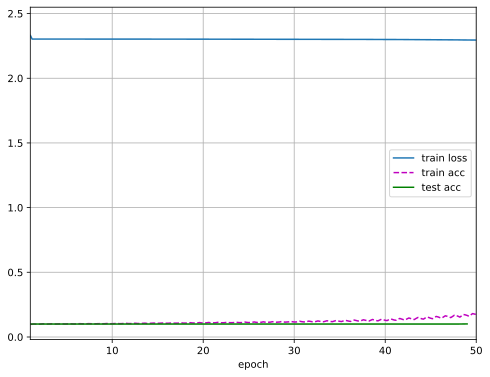

In [11]:
if __name__=="__main__":
    lr=0.01#不起作用
    num_epoches=50
    data_path="dataset"
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size=256
    train_data=torchvision.datasets.FashionMNIST(data_path,train=True,transform=transforms.Compose([transforms.ToTensor()]),download=True)
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=False)
    print("train_dataloader",len(train_dataloader))

    test_data=torchvision.datasets.FashionMNIST(data_path,train=False,transform=transforms.Compose([transforms.ToTensor()]),download=True)
    test_dataloader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)
    print("test_dataloader",len(test_dataloader))
    print("=================================================")
    train(net,train_dataloader,test_dataloader,num_epoches,lr,device)

在使用 torch.utils.data.DataLoader 时，设置 shuffle=False 通常意味着每个 epoch 加载数据的顺序都是一样的。这可能会对训练过程产生一些影响，尤其是在某些机器学习模型和任务中。

学习动态: 当数据不打乱时，模型每次看到的数据顺序都是固定的，这可能导致模型对数据的特定顺序产生过拟合，而不是学习到数据的通用特征。换句话说，模型可能只学习到如何处理特定顺序的数据，而无法泛化到新的、未见过的数据上。

梯度更新: 如果数据顺序固定，特别是当数据内部有某种顺序或模式（例如，时间序列数据或某种类别的数据连续出现）时，梯度更新可能会受到这种顺序的影响。这可能导致梯度更新不够有效，影响整体的学习过程。

逃离局部最小值: 打乱数据可以帮助模型在训练过程中探索更多的数据组合和特征，从而增加找到更好全局最小值的可能性。固定数据顺序可能使模型陷入局部最小值。

为了提高模型训练的效果和泛化能力，通常推荐在训练时设置 shuffle=True，使得每个 epoch 的数据顺序都是随机的，这有助于模型更好地学习并减少过拟合的风险。如果你发现在设置 shuffle=False 后模型训练“不动”，也就是说训练误差和验证误差没有显著变化或者模型表现不佳，尝试打乱数据可能是一个值得尝试的解决方案。








loss 0.300,train_acc 0.888,test acc 0.861
20150.414327 examples/sec on cuda


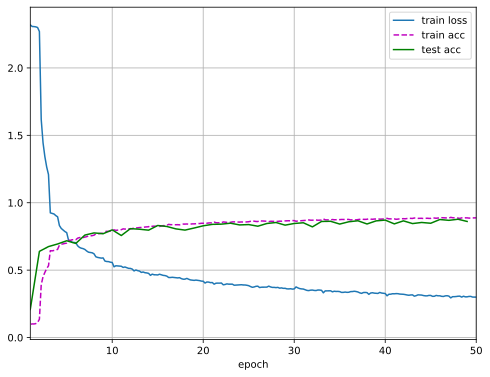

In [14]:
if __name__=="__main__":
    lr=0.5
    num_epoches=50
    data_path="dataset"
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size=256
    train_data=torchvision.datasets.FashionMNIST(data_path,train=True,transform=transforms.Compose([transforms.ToTensor()]),download=True)
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    print("train_dataloader",len(train_dataloader))

    test_data=torchvision.datasets.FashionMNIST(data_path,train=False,transform=transforms.Compose([transforms.ToTensor()]),download=True)
    test_dataloader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)
    print("test_dataloader",len(test_dataloader))
    print("=================================================")
    train(net,train_dataloader,test_dataloader,num_epoches,lr,device)

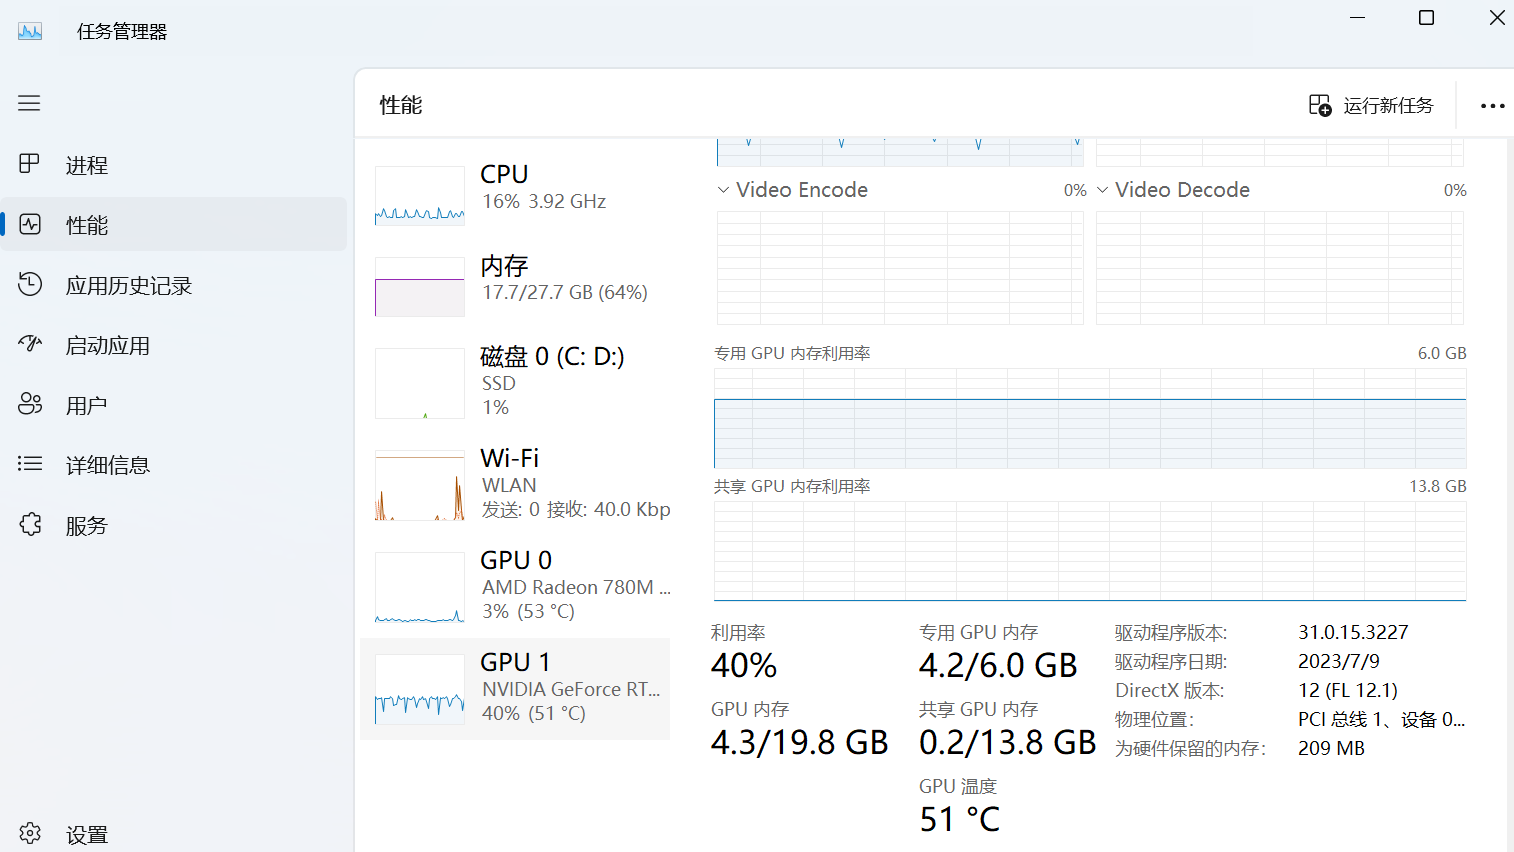